In [12]:
# Import all necessary Python packages

import os
import warnings
import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

warnings.filterwarnings("ignore")

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc, f1_score
from sklearn.pipeline import Pipeline
from IPython.display import Image


In [7]:
# Variables

fig_size = (12, 8)

In [8]:
# Loading from the Training and testing data

X_train = pd.read_csv('../data/train_data/X_train.csv')
y_train = pd.read_csv('../data/train_data/y_train.csv')

X_test = pd.read_csv('../data/test_data/X_test.csv')
y_test = pd.read_csv('../data/test_data/y_test.csv')


In [9]:
# Selected Models for the evaluation

models = [
    (LogisticRegression(), {'model__C': [0.1, 1, 10]}),
    (DecisionTreeClassifier(), {'model__max_depth': [3, 5, 7]}),
    (RandomForestClassifier(), {'model__n_estimators': [50, 100, 200]}),
    (KNeighborsClassifier(), {'model__n_neighbors': [3, 5, 7]}),
    (GaussianNB(), {}),  # Naive Bayes doesn't have hyperparameters
    (XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
     {'model__n_estimators': [50, 100, 200], 'model__max_depth': [3, 5, 7]}),
    (AdaBoostClassifier(), {'model__n_estimators': [50, 100, 200], 'model__learning_rate': [0.01, 0.1, 1]})
]



In [10]:
def build_and_evaluate_models(models, X_train, X_test, y_train, y_test):
    """
    Function used to build and evaluate the selected machine learning models on the training and testing dataset
    :param models: Having the model list information to build and evaluate
    :param X_train: Training data
    :param X_test: Testing data
    :param y_train: Target variable of the training data
    :param y_test: Target variable of the testing data
    :return: Builds the models and saves the model related information to the 'models' folder
    """
    model_names = []
    accuracies = []
    f1_scores = []
    base_path = '../models'
    os.makedirs(base_path, exist_ok=True)
    fprs, tprs, roc_aucs, model_labels = [], [], [], []
    for model, params in models:
        model_name = model.__class__.__name__
        print(f"Building and Evaluation of the model: {model_name}")
        model_path = os.path.join(base_path, model_name)
        os.makedirs(model_path, exist_ok=True)

        pipe = Pipeline([('model', model)])
        grid_search = GridSearchCV(pipe, params, cv=5, scoring='accuracy')
        grid_search.fit(X_train, y_train)
        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_test)

        # Save the model
        joblib.dump(best_model, os.path.join(model_path, f'{model_name}.joblib'))

        # Accuracy
        accuracy = accuracy_score(y_test, y_pred)
        accuracies.append(accuracy)
        model_names.append(model_name)

        # F1 Score
        f1 = f1_score(y_test, y_pred)
        f1_scores.append(f1)

        # Classification Report
        report = classification_report(y_test, y_pred)
        with open(os.path.join(model_path, 'classification_report.txt'), 'w') as f:
            f.write(report)

        # Confusion Matrix
        plt.figure(figsize=fig_size)
        cm = confusion_matrix(y_test, y_pred)
        sns.heatmap(cm, annot=True, fmt="d")
        plt.title(f"Confusion Matrix for {model_name}")
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.savefig(os.path.join(model_path, 'confusion_matrix.png'))
        plt.close()

        # ROC Curve
        if len(np.unique(y_test)) == 2:  # Check if binary classification
            y_prob = best_model.predict_proba(X_test)[:, 1]
            fpr, tpr, thresholds = roc_curve(y_test, y_prob)
            roc_auc = auc(fpr, tpr)
            plt.figure(figsize=fig_size)
            plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
            plt.plot([0, 1], [0, 1], 'k--')
            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.05])
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title(f'ROC Curve for {model_name}')
            plt.legend(loc="lower right")
            plt.savefig(os.path.join(model_path, 'roc_curve.png'))
            plt.close()
            # Store FPR, TPR, and AUC for later plotting
            fprs.append(fpr)
            tprs.append(tpr)
            roc_aucs.append(roc_auc)
            model_labels.append(model_name)

        if hasattr(best_model.named_steps['model'], 'feature_importances_'):
            importances = best_model.named_steps['model'].feature_importances_

            # Sort the feature importances in descending order
            indices = np.argsort(importances)[::-1]

            feature_names = np.array(X_train.columns)

            # Plotting the feature importances
            plt.figure(figsize=fig_size)
            plt.title("Feature Importances")
            plt.bar(range(X_train.shape[1]), importances[indices], color="steelblue", align="center")
            plt.xticks(range(X_train.shape[1]), [feature_names[i] for i in indices], rotation=90)
            plt.xlim([-1, X_train.shape[1]])
            plt.xlabel("Feature")
            plt.ylabel("Importance")
            plt.tight_layout()
            plt.savefig(os.path.join(model_path, 'feature_importance.png'))
            plt.close()
        else:
            print(f"The model in the pipeline does not support feature importances.")

    # Plotting model comparison for Accuracy
    plt.figure(figsize=fig_size)
    sns.barplot(x=model_names, y=accuracies)
    plt.title('Model Comparison - Accuracy')
    plt.xlabel('Model')
    plt.ylabel('Accuracy')
    plt.xticks(rotation=45)
    plt.savefig(os.path.join(base_path, 'model_accuracy_comparison.png'))
    plt.close()

    # Assuming you have calculated and appended F1 scores in f1_scores list
    # Plotting model comparison for F1 Score
    plt.figure(figsize=fig_size)
    sns.barplot(x=model_names, y=f1_scores)
    plt.title('Model Comparison - F1 Score')
    plt.xlabel('Model')
    plt.ylabel('F1 Score')
    plt.xticks(rotation=45)
    plt.savefig(os.path.join(base_path, 'model_f1_score_comparison.png'))
    plt.close()

    plt.figure(figsize=fig_size)
    for fpr, tpr, roc_auc, label in zip(fprs, tprs, roc_aucs, model_labels):
        plt.plot(fpr, tpr, label=f'{label} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--', label='Chance (AUC = 0.50)')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves Comparison')
    plt.legend(loc="lower right")
    plt.savefig(os.path.join(base_path, 'roc_curves_comparison.png'))
    plt.close()


In [11]:

build_and_evaluate_models(models, X_train, X_test, y_train, y_test)


Building and Evaluation of the model: LogisticRegression
The model in the pipeline does not support feature importances.
Building and Evaluation of the model: DecisionTreeClassifier
Building and Evaluation of the model: RandomForestClassifier
Building and Evaluation of the model: KNeighborsClassifier
The model in the pipeline does not support feature importances.
Building and Evaluation of the model: GaussianNB
The model in the pipeline does not support feature importances.
Building and Evaluation of the model: XGBClassifier
Building and Evaluation of the model: AdaBoostClassifier


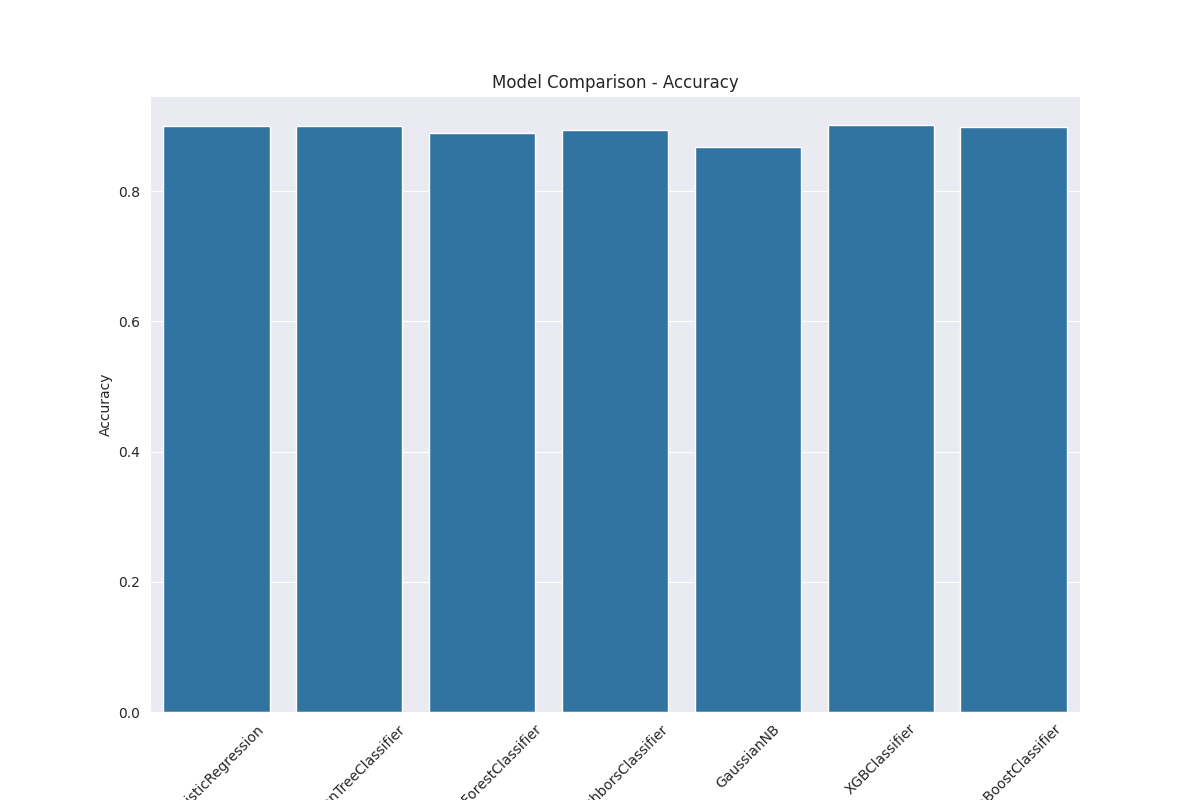

In [13]:
# Comparison of Accuracy for different models

Image(filename='../models/model_accuracy_comparison.png')

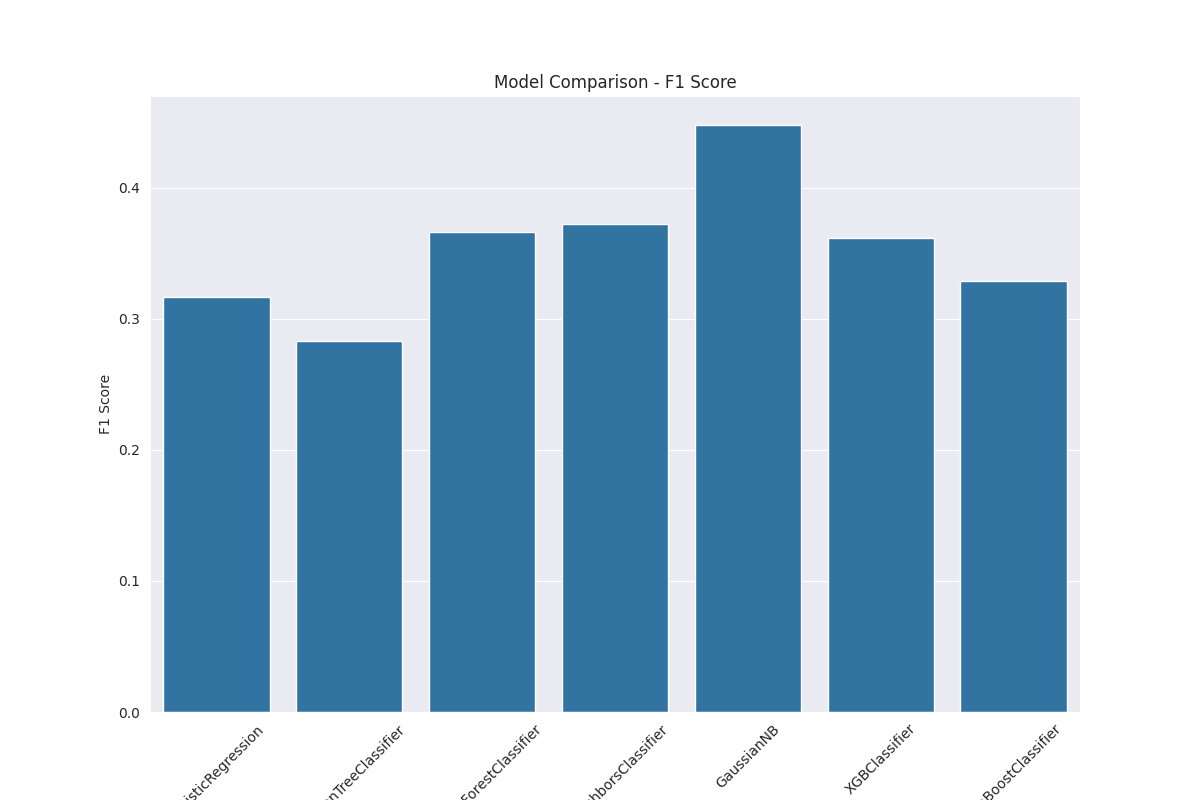

In [14]:
# Comparison of F1 for different models

Image(filename='../models/model_f1_score_comparison.png')

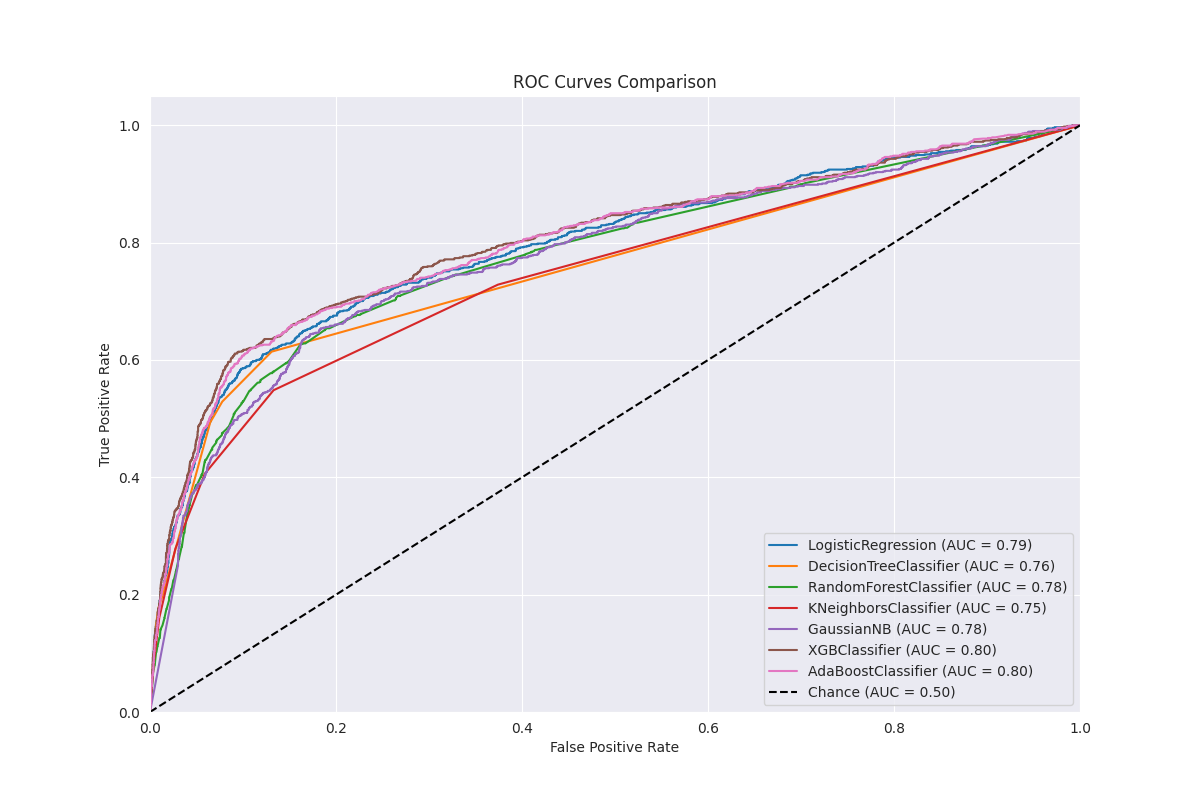

In [15]:
# Comparison of ROC Curve for different models

Image(filename='../models/roc_curves_comparison.png')